<a href="https://colab.research.google.com/github/Saku052/GlobalOSMarketShare/blob/main/GlobalOSMarketShare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import scipy.stats as st

In [137]:
#グローバルマーケットシェアのデータをインポート
Orig_df = pd.read_csv("/content/gloabal_marketshare.csv")
Orig_df.tail(3)

,Date,WinTotal,Win7,Win10,Win 8.1,Win 8,WinXP,WinVista,Windows,MacOSX,iOS,Android,Tablet,Linux,Chrome OS,Other
114,Jul '21,68.38,NaN,NaN,NaN,NaN,NaN,NaN,68.38,14.44,3.42,2.77,6.19,2.23,1.13,7.63
115,Aug '21,71.13,NaN,NaN,NaN,NaN,NaN,NaN,71.13,15.08,3.52,2.85,6.37,2.23,1.62,3.57
116,Sep '21,71.06,NaN,NaN,NaN,NaN,NaN,NaN,71.06,15.01,3.02,2.51,5.53,2.20,2.44,3.76


In [138]:
#必要データだけをまとめる
Dropped_df = pd.DataFrame(
    data = {"MacOS" : Orig_df["MacOSX"].dropna(),
            "WINDOWS" : Orig_df["Windows"].dropna()}
)
df = Dropped_df.dropna()
df.tail(5)

,MacOS,WINDOWS
112,14.87,68.94
113,14.16,68.54
114,14.44,68.38
115,15.08,71.13
116,15.01,71.06


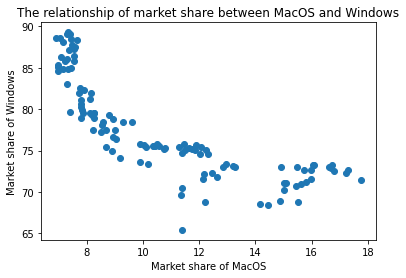

In [139]:
#離散図の描写
plt.scatter(df["MacOS"], df["WINDOWS"])
plt.xlabel("Market share of MacOS")
plt.ylabel("Market share of Windows")
plt.title("The relationship of market share between MacOS and Windows")
plt.show()

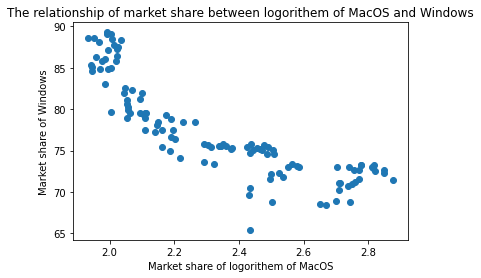

In [140]:
#MacOSのLOGをとった新たな変数の作成
df["LogMac"] = np.log(df["MacOS"])

#離散図の描写
plt.scatter(df["LogMac"], df["WINDOWS"])
plt.xlabel("Market share of logorithem of MacOS")
plt.ylabel("Market share of Windows")
plt.title("The relationship of market share between logorithem of MacOS and Windows")
plt.show()

In [141]:
#モデルの生成
model = sm.ols("WINDOWS~LogMac", df).fit()
print(model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.727   
Dependent Variable: WINDOWS          AIC:                593.9172
Date:               2022-11-24 03:40 BIC:                599.4416
No. Observations:   117              Log-Likelihood:     -294.96 
Df Model:           1                F-statistic:        309.8   
Df Residuals:       115              Prob (F-statistic): 2.03e-34
R-squared:          0.729            Scale:              9.2202  
-----------------------------------------------------------------
               Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
-----------------------------------------------------------------
Intercept     117.5535   2.2947  51.2291 0.0000 113.0082 122.0988
LogMac        -17.2562   0.9804 -17.6007 0.0000 -19.1982 -15.3141
-----------------------------------------------------------------
Omnibus:               0.266        Durbin-Watson:          0.252
Prob(Omnibus):         0.87

In [142]:
#Windows_hatの生成と、残差の計算
df["Win_pred"] = model.predict(df)
df["Residuals"] = df["Win_pred"] - df["WINDOWS"]
df.tail(3)

,MacOS,WINDOWS,LogMac,Win_pred,Residuals
114,14.44,68.38,2.670002,71.479520,3.099520
115,15.08,71.13,2.713369,70.731169,-0.398831
116,15.01,71.06,2.708717,70.811457,-0.248543


In [143]:
#正規分布の生成と、残差の正規性
df["Residuals"] = st.zscore(df["Residuals"])

def CreateNDist(data):
  n_norm = np.linspace(data.min(), data.max(), 1000)
  p_norm = []
  for i in range(len(n_norm)):
    p_norm.append(st.norm.pdf(x = n_norm[i], loc = 0, scale = 1))
  return n_norm, p_norm

n, p = CreateNDist(df["Residuals"])

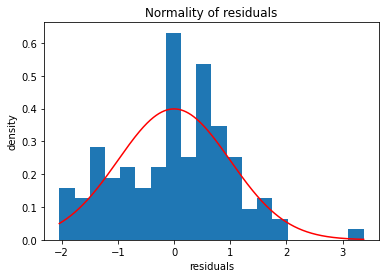

In [144]:
#分布の描写
plt.hist(df["Residuals"], density = True, bins = 20)
plt.plot(n, p, color = "red")
plt.title("Normality of residuals")
plt.xlabel("residuals")
plt.ylabel("density")
plt.show()

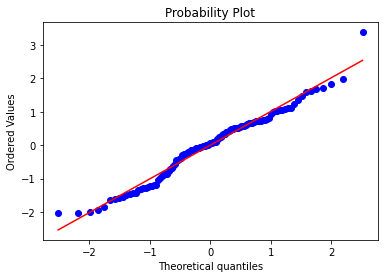

In [145]:
#Q-Q plotから正規性を判断する
st.probplot(df["Residuals"], dist = "norm", plot = plt)
plt.show()

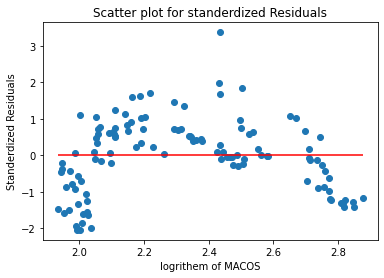

In [153]:
#check the dependency and cosntant variance of the Residuals
plt.scatter(df["LogMac"], df["Residuals"])
plt.hlines(0, df["LogMac"].min(), df["LogMac"].max(), color = "red")
plt.title("Scatter plot for standerdized Residuals")
plt.xlabel("logrithem of MACOS")
plt.ylabel("Standerdized Residuals")
plt.show()

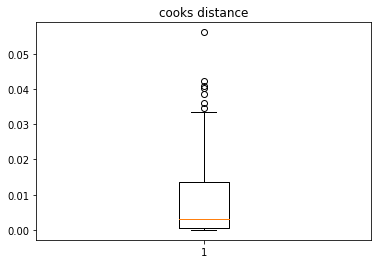

In [147]:
#クックの距離から外れ値を測定する
df_infl = model.get_influence().summary_frame()
plt.boxplot(df_infl["cooks_d"])
plt.title("cooks distance")
plt.show()

In [148]:
#クックの距離0.03を超えているデータをドロップ
def getindexOutliear(cooksd):
  outlier = cooksd[(cooksd > 0.03)]
  return outlier.index

filtered_df = df.drop(getindexOutliear(df_infl["cooks_d"]))
filtered_df.reset_index(inplace=True)
filtered_df.tail(3)

,index,MacOS,WINDOWS,LogMac,Win_pred,Residuals
104,114,14.44,68.38,2.670002,71.479520,1.029602
105,115,15.08,71.13,2.713369,70.731169,-0.132484
106,116,15.01,71.06,2.708717,70.811457,-0.082561


In [149]:
#新規モデルの生成
model2 = sm.ols("WINDOWS~LogMac", filtered_df).fit()
print(model2.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.764   
Dependent Variable: WINDOWS          AIC:                509.2752
Date:               2022-11-24 03:40 BIC:                514.6209
No. Observations:   107              Log-Likelihood:     -252.64 
Df Model:           1                F-statistic:        343.7   
Df Residuals:       105              Prob (F-statistic): 6.82e-35
R-squared:          0.766            Scale:              6.7073  
-----------------------------------------------------------------
               Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
-----------------------------------------------------------------
Intercept     116.6425   2.1403  54.4986 0.0000 112.3987 120.8863
LogMac        -17.0061   0.9174 -18.5381 0.0000 -18.8251 -15.1872
-----------------------------------------------------------------
Omnibus:              1.734        Durbin-Watson:           0.255
Prob(Omnibus):        0.420

In [150]:
#Windows_hatの生成と、残差の計算
filtered_df["New_Win_pred"] = model2.predict(filtered_df)
filtered_df["New_Residuals"] = filtered_df["New_Win_pred"] - filtered_df["WINDOWS"]
filtered_df.tail(3)

,index,MacOS,WINDOWS,LogMac,Win_pred,Residuals,New_Win_pred,New_Residuals
104,114,14.44,68.38,2.670002,71.479520,1.029602,71.236107,2.856107
105,115,15.08,71.13,2.713369,70.731169,-0.132484,70.498598,-0.631402
106,116,15.01,71.06,2.708717,70.811457,-0.082561,70.577723,-0.482277


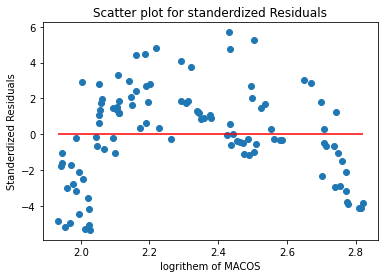

In [154]:
#check the dependency and cosntant variance of the Residuals
plt.scatter(filtered_df["LogMac"], filtered_df["New_Residuals"])
plt.hlines(0, filtered_df["LogMac"].min(), filtered_df["LogMac"].max(), color = "red")
plt.title("Scatter plot for standerdized Residuals")
plt.xlabel("logrithem of MACOS")
plt.ylabel("Standerdized Residuals")
plt.show()